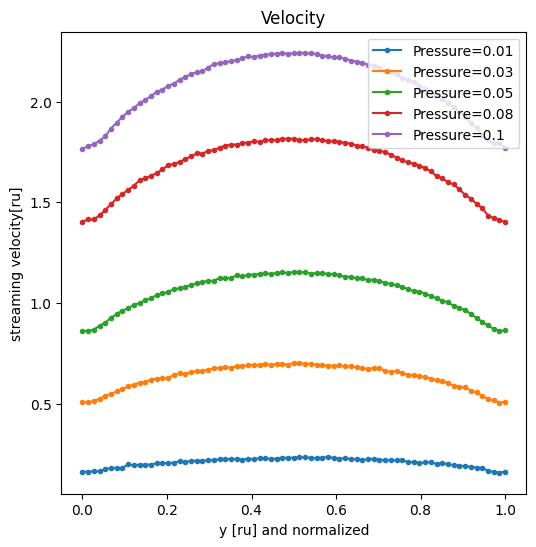

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

#Function to somewhat clean up the spiking action going on at the walls, only used for velocity
def cleanSpikes(arr,diff,replace):
    newz = []
    for i,coord in enumerate(arr):
        if(i==0):
            newz.append(coord)
            continue
        if(np.abs(coord-newz[-1]) > diff or coord<0):
            newz.append(replace)
        else: newz.append(coord)
    return newz

def getTable(file):
    table = pd.read_csv(file,delimiter=" ",header=None,names=["pos_z","density","velocity","temperature"])
    wall_mask = table["density"] > 0.07
    table["pos_z"] = table["pos_z"][wall_mask]
    table["density"] = table["density"][wall_mask]
    table["velocity"] = table["velocity"][wall_mask]
    table["temperature"] = table["temperature"][wall_mask]

    table["pos_z"] =  table["pos_z"] - table["pos_z"].min()
    return table

def plotAll(ax,table,lbl):
    ax[0].plot(table["pos_z"]/table["pos_z"].max(),table["density"],label=lbl,marker=".")
    ax[0].set_title("Density")
    # ax[0].set_ylim(0.4,0.52)
    ax[0].set_ylim(0.01,0.2)
    ax[0].set_xlabel("y [ru] and normalized")
    ax[0].set_ylabel("density [ru]")
    ax[0].legend()

    ax[1].plot(table["pos_z"]/table["pos_z"].max(),table["velocity"],label=lbl,marker=".")
    ax[1].set_title("Velocity")
    ax[1].set_xlabel("y [ru] and normalized")
    ax[1].set_ylabel("streaming velocity[ru]")
    ax[1].legend()

    ax[2].plot(table["pos_z"]/table["pos_z"].max(),table["temperature"],label=lbl,marker=".")
    ax[2].set_title("Temperature")
    ax[2].set_xlabel("y [ru] and normalized")
    ax[2].set_ylabel("temperature [ru]")
    ax[2].legend()

def plotV(table,lbl):
    plt.plot(table["pos_z"]/table["pos_z"].max(),table["velocity"],label=lbl,marker=".")
    plt.title("Velocity")
    plt.xlabel("y [ru] and normalized")
    plt.ylabel("streaming velocity[ru]")
    plt.legend()



def plot(ax,file,lbl,all):
    table = getTable(f'../Tests/{file}.dat')
    if all:
        plotAll(ax,table,lbl)
    else:
        plotV(table,lbl)

all = not True

fig,ax = plt.subplots(1,3 if all else 1,sharex=False,figsize=(15 if all else 6,6))

# plot(ax,"WG9","channel width = 5",all)
# plot(ax,"WG8","channel width = 8",all)
# plot(ax,"WG1","Pressure=0.01",all)
# plot(ax,"WG2","channel width = 12",all)
# plot(ax,"WG3","channel width = 15",all)
# plot(ax,"WG4","Pressure=0.03",all)
# plot(ax,"WG5","Pressure=0.05",all)
# plot(ax,"WG6","Pressure=0.08",all)
# plot(ax,"WG7","Pressure=0.1",all)

# plot(ax,"WAu9","channel width = 5",all)
# plot(ax,"WAu8","channel width = 8",all)
plot(ax,"WAu1","Pressure=0.01",all)
# plot(ax,"WAu2","channel width = 12",all)
# plot(ax,"WAu3","channel width = 15",all)
plot(ax,"WAu4","Pressure=0.03",all)
plot(ax,"WAu5","Pressure=0.05",all)
plot(ax,"WAu6","Pressure=0.08",all)
plot(ax,"WAu7","Pressure=0.1",all)


L_S: 4.3337770173965495


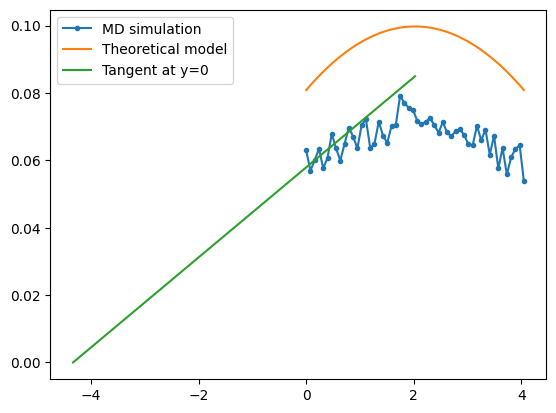

In [84]:
def parabola(x,a,b,c):
    return x**2*a+x*b+c

def findSlipLengthCF(x,y):
    vars,cov=curve_fit(parabola,x.dropna(),y.dropna(),absolute_sigma=True)
    L_s = -vars[2]/vars[1]
    return np.abs(L_s),vars[0],vars[1],vars[2]

def momentumPFlowEquation(y,rho,mu,P,A,B):
    return y**2/(rho*mu*2)*P-y*A-B

def neumannSlip(Ls,channel_width,rho,mu,P):
    A = (P*channel_width)/(rho*mu*2)
    B = Ls*A
    return A,B


def plotModel(file,P,rho,mu,tanget):
    data = getTable(f'../Tests/{file}.dat')
    cw = data["pos_z"].max() - data["pos_z"].min()
    L_s,a,b,c = findSlipLengthCF(data["pos_z"],data["velocity"])

    A,B = neumannSlip(L_s,cw,rho,mu,P)

    Y = np.linspace(0,cw)

    plt.plot(data["pos_z"],data["velocity"],label="MD simulation",marker=".")
    plt.plot(Y,momentumPFlowEquation(Y,rho,mu,P,A,B),label="Theoretical model")
    if tanget:
        Y_t = np.linspace(-L_s,cw/2)
        plt.plot(Y_t,Y_t*b+c,label="Tangent at y=0")
    plt.legend()
    print(f'L_S: {L_s}')


file = "WAu9"
P = -0.01
rho = 0.44

eps_FF = 30.67*1.6*10**(-22)
sig_FF = 2.735*10**(-10)
m = 2.988*10**(-26)

mu = 0.000399*sig_FF**2/np.sqrt(m*eps_FF)

plotModel(file,P,rho,mu,True)
